In [1]:
from dotenv import load_dotenv
import os
import pandas as pd
import math
import json
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from torch.optim import AdamW
from torch.amp import autocast
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, log_loss

load_dotenv()

In [8]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
os.environ["HF_HOME"] = os.getenv("HF_HOME")
os.environ["HF_HOME"]

'/media/luna/huggingface'

In [5]:
DATA_DIR = os.getenv("DATA_DIR")
DATA_DIR

'data'

In [6]:
MODELS_DIR = os.getenv("MODELS_DIR")
MODELS_DIR

'models'

In [24]:
STATISTIC_DIR = os.getenv("STATISTIC_DIR")
STATISTIC_DIR

'statistic'

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='cuda')

In [10]:
train_data = pd.read_json(os.path.join(DATA_DIR, 'data_final_for_dls_new.jsonl'), orient='orient', lines=True)[570:]
train_data = train_data[train_data['relevance'] != 0.1]
train_data = train_data.fillna("")
train_data

Text  \
570                                       –Ω–∞–ª–æ–≥–æ–≤–∞—è 5007   
571                                  —à—É–≥–∞—Ä–∏–Ω–≥ –ö—Ä–∞—Å–Ω–æ—è—Ä—Å–∫   
573                     –Ω–æ–≤–æ–≥–æ–¥–Ω—è—è –Ω–æ—á—å 2018 –≤ —Ä–µ—Å—Ç–æ—Ä–∞–Ω–µ   
574    –±–∞–ª–µ—Ç–Ω–∞—è —à–∫–æ–ª–∞ –≤ —Å–∞–Ω–∫—Ç –ø–µ—Ç–µ—Ä–±—É—Ä–≥–µ 12–ª–µ—Ç —Å –ø—Ä–æ–∂...   
575                                 —Å–æ–ª–∫–æ—Å–µ—Ä–∏–ª –≥–µ–ª—å —Ü–µ–Ω–∞   
...                                                  ...   
35089                                    –Ω–æ—Ç–∞—Ä–∏—É—Å –∑–∞–ø–∏—Å—å   
35090                          —Å—Ç–∞—Ü–∏–æ–Ω–∞—Ä –¥–ª—è –∫–æ—Ç–∞ –º–æ—Å–∫–≤–∞   
35091                                        –∞–≥–∑—Å –ø—Ä–æ–ø–∞–Ω   
35092                               –≥–¥–µ –≤–∏–±—Ä–∏—Ç—å –≤–∞–∑ 2112   
35093                                        –ê–ø–∞—Ä—Ç –æ—Ç–µ–ª—å   

                                                 address  \
570     –ú–æ—Å–∫–æ–≤—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å, –ö–æ—Ä–æ–ª—ë–≤, —É–ª–∏—Ü–∞ –ë–æ–≥–æ–º–æ–ª–æ–≤–∞, 4   
571       –ö—Ä–∞—Å–Ω–æ—è—Ä—Å–∫, –º–∏–∫—Ä–æ—Ä–∞–π–æ–Ω –í–∑–ª—ë—Ç–∫–∞, —É–ª–∏—Ü–∞ –í–µ—Å–Ω—ã, 3   
573                    –ú–æ—Å–∫–≤–∞, –ö—É—Ç—É–∑–æ–≤—Å–∫–∏–π –ø—Ä–æ—Å–ø–µ–∫—Ç, 36–ê   
574               –°–∞–Ω–∫—Ç-–ü–µ—Ç–µ—Ä–±—É—Ä–≥, –ù–µ–≤—Å–∫–∏–π –ø—Ä–æ—Å–ø–µ–∫—Ç, 35–í   
575         –ú–æ—Å–∫–≤–∞, –°–∏–º—Ñ–µ—Ä–æ–ø–æ–ª—å—Å–∫–∏–π –±—É–ª—å–≤–∞—Ä, 29, –∫–æ—Ä–ø. 1   
...                                                  ...   
35089                    –ú–æ—Å–∫–≤–∞, 15-—è –ü–∞—Ä–∫–æ–≤–∞—è —É–ª–∏—Ü–∞, 45   
35090         –ú–æ—Å–∫–≤–∞, —É–ª–∏—Ü–∞ –ì–æ—Å–ø–∏—Ç–∞–ª—å–Ω—ã–π –í–∞–ª, 3, –∫–æ—Ä–ø. 5   
35091        –°–∞–º–∞—Ä–∞, —É–ª–∏—Ü–∞ 22-–≥–æ –ü–∞—Ä—Ç—Å—ä–µ–∑–¥–∞, 49, –∫–æ—Ä–ø. 1   
35092              –ù–∏–∂–Ω–∏–π –ù–æ–≤–≥–æ—Ä–æ–¥, –ú–æ—Å–∫–æ–≤—Å–∫–æ–µ —à–æ—Å—Å–µ, 34   
35093  –ö—Ä–∞—Å–Ω–æ–¥–∞—Ä—Å–∫–∏–π –∫—Ä–∞–π, –≥–æ—Ä–æ–¥—Å–∫–æ–π –æ–∫—Ä—É–≥ –°–æ—á–∏, —Å–µ–ª–æ...   

                                                    name  \
570    –ù–∞–ª–æ–≥–æ–≤–∞—è —Å–ª—É–∂–±–∞; –ú–µ–∂—Ä–∞–π–æ–Ω–Ω–∞—è –ò–§–ù–° ‚Ññ 2; –ò–§–ù–° ‚Ññ...   
571             –°—Ç—É–¥–∏—è –∫—Ä–∞—Å–æ—Ç—ã –î–∞—Ä–ª–∏–Ω–≥; Darling; –î–∞—Ä–ª–∏–Ω–≥   
573    Atlantica seafood; –ö–æ–ª–ª–µ–∫—Ü–∏—è; –ö–æ–ª–ª–µ–∫—Ü–∏—è Food &...   
574    –†—É—Å—Å–∫–∞—è –Ω–∞—Ü–∏–æ–Ω–∞–ª—å–Ω–∞—è –±–∞–ª–µ—Ç–Ω–∞—è —à–∫–æ–ª–∞ –ò–ª–∑–µ –õ–∏–µ–ø–∞...   
575                –°—Ç–æ–ª–∏—á–∫–∏; Stolichki; Apteki Stolichki   
...                                                  ...   
35089  –ù–æ—Ç–∞—Ä–∏—É—Å –û. –ù. –°–∞–≤–∏–Ω–∞; Notarius O. N. Savina; ...   
35090     –¢—Ä–∏–æ–í–µ—Ç; Triovet; –¢—Ä–∏–æ–≤–µ—Ç; Veterinaria Triovet   
35091                      –†–æ–∑–∞ –ú–∏—Ä–∞; –ê–ó–° ‚Ññ 2; –†–æ–∑–∞ –º–∏—Ä–∞   
35092  –ù–∏–∂–µ–≥–æ—Ä–æ–¥–µ—Ü, Lada; Nizhegorodec, Lada; –ù–∏–∂–µ–≥–æ—Ä...   
35093                                    Chalet Terrazza   

      normalized_main_rubric_name_ru     permalink  \
570              –ù–∞–ª–æ–≥–æ–≤–∞—è –∏–Ω—Å–ø–µ–∫—Ü–∏—è    1377658436   
571                    –°–∞–ª–æ–Ω –∫—Ä–∞—Å–æ—Ç—ã    1085001465   
573                         –†–µ—Å—Ç–æ—Ä–∞–Ω    1187477091   
574                     –®–∫–æ–ª–∞ —Ç–∞–Ω—Ü–µ–≤  172170646460   
575                           –ê–ø—Ç–µ–∫–∞  226500195223   
...                              ...           ...   
35089                      –ù–æ—Ç–∞—Ä–∏—É—Å—ã    1056199530   
35090           –í–µ—Ç–µ—Ä–∏–Ω–∞—Ä–Ω–∞—è –∫–ª–∏–Ω–∏–∫–∞  133156701339   
35091                            –ê–ó–°    6884296946   
35092                      –ê–≤—Ç–æ—Å–∞–ª–æ–Ω  124836381099   
35093                      –ì–æ—Å—Ç–∏–Ω–∏—Ü–∞  131157990871   

                                       prices_summarized  relevance  \
570                                                             0.0   
571    –°—Ç—É–¥–∏—è –∫—Ä–∞—Å–æ—Ç—ã ¬´–î–∞—Ä–ª–∏–Ω–≥¬ª –ø—Ä–µ–¥–æ—Å—Ç–∞–≤–ª—è–µ—Ç —É—Å–ª—É–≥–∏ ...        1.0   
573    –†–µ—Å—Ç–æ—Ä–∞–Ω Atlantica –ø—Ä–µ–¥–ª–∞–≥–∞–µ—Ç —Ä–∞–∑–Ω–æ–æ–±—Ä–∞–∑–Ω—ã–µ –±–ª...        1.0   
574                                                             0.0   
575    –ê–ø—Ç–µ–∫–∞ ¬´

In [11]:
X = train_data.drop(columns=['relevance', 'relevance_new', 'address', 'permalink'])
X

Text  \
570                                       –Ω–∞–ª–æ–≥–æ–≤–∞—è 5007   
571                                  —à—É–≥–∞—Ä–∏–Ω–≥ –ö—Ä–∞—Å–Ω–æ—è—Ä—Å–∫   
573                     –Ω–æ–≤–æ–≥–æ–¥–Ω—è—è –Ω–æ—á—å 2018 –≤ —Ä–µ—Å—Ç–æ—Ä–∞–Ω–µ   
574    –±–∞–ª–µ—Ç–Ω–∞—è —à–∫–æ–ª–∞ –≤ —Å–∞–Ω–∫—Ç –ø–µ—Ç–µ—Ä–±—É—Ä–≥–µ 12–ª–µ—Ç —Å –ø—Ä–æ–∂...   
575                                 —Å–æ–ª–∫–æ—Å–µ—Ä–∏–ª –≥–µ–ª—å —Ü–µ–Ω–∞   
...                                                  ...   
35089                                    –Ω–æ—Ç–∞—Ä–∏—É—Å –∑–∞–ø–∏—Å—å   
35090                          —Å—Ç–∞—Ü–∏–æ–Ω–∞—Ä –¥–ª—è –∫–æ—Ç–∞ –º–æ—Å–∫–≤–∞   
35091                                        –∞–≥–∑—Å –ø—Ä–æ–ø–∞–Ω   
35092                               –≥–¥–µ –≤–∏–±—Ä–∏—Ç—å –≤–∞–∑ 2112   
35093                                        –ê–ø–∞—Ä—Ç –æ—Ç–µ–ª—å   

                                                    name  \
570    –ù–∞–ª–æ–≥–æ–≤–∞—è —Å–ª—É–∂–±–∞; –ú–µ–∂—Ä–∞–π–æ–Ω–Ω–∞—è –ò–§–ù–° ‚Ññ 2; –ò–§–ù–° ‚Ññ...   
571             –°—Ç—É–¥–∏—è –∫—Ä–∞—Å–æ—Ç—ã –î–∞—Ä–ª–∏–Ω–≥; Darling; –î–∞—Ä–ª–∏–Ω–≥   
573    Atlantica seafood; –ö–æ–ª–ª–µ–∫—Ü–∏—è; –ö–æ–ª–ª–µ–∫—Ü–∏—è Food &...   
574    –†—É—Å—Å–∫–∞—è –Ω–∞—Ü–∏–æ–Ω–∞–ª—å–Ω–∞—è –±–∞–ª–µ—Ç–Ω–∞—è —à–∫–æ–ª–∞ –ò–ª–∑–µ –õ–∏–µ–ø–∞...   
575                –°—Ç–æ–ª–∏—á–∫–∏; Stolichki; Apteki Stolichki   
...                                                  ...   
35089  –ù–æ—Ç–∞—Ä–∏—É—Å –û. –ù. –°–∞–≤–∏–Ω–∞; Notarius O. N. Savina; ...   
35090     –¢—Ä–∏–æ–í–µ—Ç; Triovet; –¢—Ä–∏–æ–≤–µ—Ç; Veterinaria Triovet   
35091                      –†–æ–∑–∞ –ú–∏—Ä–∞; –ê–ó–° ‚Ññ 2; –†–æ–∑–∞ –º–∏—Ä–∞   
35092  –ù–∏–∂–µ–≥–æ—Ä–æ–¥–µ—Ü, Lada; Nizhegorodec, Lada; –ù–∏–∂–µ–≥–æ—Ä...   
35093                                    Chalet Terrazza   

      normalized_main_rubric_name_ru  \
570              –ù–∞–ª–æ–≥–æ–≤–∞—è –∏–Ω—Å–ø–µ–∫—Ü–∏—è   
571                    –°–∞–ª–æ–Ω –∫—Ä–∞—Å–æ—Ç—ã   
573                         –†–µ—Å—Ç–æ—Ä–∞–Ω   
574                     –®–∫–æ–ª–∞ —Ç–∞–Ω—Ü–µ–≤   
575                           –ê–ø—Ç–µ–∫–∞   
...                              ...   
35089                      –ù–æ—Ç–∞—Ä–∏—É—Å—ã   
35090           –í–µ—Ç–µ—Ä–∏–Ω–∞—Ä–Ω–∞—è –∫–ª–∏–Ω–∏–∫–∞   
35091                            –ê–ó–°   
35092                      –ê–≤—Ç–æ—Å–∞–ª–æ–Ω   
35093                      –ì–æ—Å—Ç–∏–Ω–∏—Ü–∞   

                                       prices_summarized  \
570                                                        
571    –°—Ç—É–¥–∏—è –∫—Ä–∞—Å–æ—Ç—ã ¬´–î–∞—Ä–ª–∏–Ω–≥¬ª –ø—Ä–µ–¥–æ—Å—Ç–∞–≤–ª—è–µ—Ç —É—Å–ª—É–≥–∏ ...   
573    –†–µ—Å—Ç–æ—Ä–∞–Ω Atlantica –ø—Ä–µ–¥–ª–∞–≥–∞–µ—Ç —Ä–∞–∑–Ω–æ–æ–±—Ä–∞–∑–Ω—ã–µ –±–ª...   
574                                                        
575    –ê–ø—Ç–µ–∫–∞ ¬´–°—Ç–æ–ª–∏—á–∫–∏¬ª –ø—Ä–µ–¥–ª–∞–≥–∞–µ—Ç —à–∏—Ä–æ–∫–∏–π —Å–ø–µ–∫—Ç—Ä –ª–µ...   
...                                                  ...   
35089                                                      
35090  –í–µ—Ç–µ—Ä–∏–Ω–∞—Ä–Ω–∞—è –∫–ª–∏–Ω–∏–∫–∞, –∞–ø—Ç–µ–∫–∞ –∏ –ª–∞–±–æ—Ä–∞—Ç–æ—Ä–∏—è ¬´–¢—Ä...   
35091                                                      
35092  –ê–≤—Ç–æ—Å–∞–ª–æ–Ω ¬´–ù–∏–∂–µ–≥–æ—Ä–æ–¥–µ—Ü¬ª –ø—Ä–µ–¥–ª–∞–≥–∞–µ—Ç –Ω–æ–≤—ã–µ –∞–≤—Ç–æ–º...   
35093                                                      

                                      reviews_summarized  
570    –û—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è –∑–∞–Ω–∏–º–∞–µ—Ç—Å—è –æ–±—Å–ª—É–∂–∏–≤–∞–Ω–∏–µ–º –Ω–∞–ª–æ–≥–æ–ø–ª–∞...  
571    –°—Ç—É–¥–∏—è –∫—Ä–∞—Å–æ—Ç—ã ¬´–î–∞—Ä–ª–∏–Ω–≥¬ª –ø—Ä–µ–¥–æ—Å—Ç–∞–≤–ª—è–µ—Ç –±—å—é—Ç–∏-—É...  
573    –û—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è –∑–∞–Ω–∏–º–∞–µ—Ç—Å—è —Ä–µ—Å—Ç–æ—Ä–∞–Ω–Ω—ã–º –±–∏–∑–Ω–µ—Å–æ–º –∏ ...  
574    –û—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è –∑–∞–Ω–∏–º–∞–µ—Ç—Å—è –æ–±—É—á–µ–Ω–∏–µ–º –±–∞–ª–µ—Ç—É –∏ —Ö–æ—Ä–µ...  
575    –û—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è –∑–∞–Ω–∏–º–∞–µ—Ç—Å—è –ø—Ä–æ–¥–∞–∂–µ–π –ª–µ–∫–∞—Ä—Å—Ç–≤ –∏ –º–µ–¥...  
...                                                  ...  
35089  –û—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è –ø—Ä–µ–¥–æ—Å—Ç–∞–≤–ª—è–µ—Ç –Ω–æ—Ç–∞—Ä–∏–∞–ª—å–Ω—ã–µ —É—Å–ª—É–≥–∏ ...  
35090  –û—

In [12]:
# –û–±—ä–µ–¥–∏–Ω–µ–Ω–∏–µ —Ç–µ–∫—Å—Ç–æ–≤—ã—Ö –ø–æ–ª–µ–π
def combine_fields(row):
    return f"–ó–∞–ø—Ä–æ—Å: {row['Text']} | –ù–∞–∑–≤–∞–Ω–∏–µ: {row['name']} | –†—É–±—Ä–∏–∫–∞: {row['normalized_main_rubric_name_ru']} | –û–ø–∏—Å–∞–Ω–∏–µ: {row['prices_summarized']} | –û—Ç–∑—ã–≤—ã: {row['reviews_summarized']}"

In [13]:
X['combined_fields'] = X.apply(combine_fields, axis=1)
X

Text  \
570                                       –Ω–∞–ª–æ–≥–æ–≤–∞—è 5007   
571                                  —à—É–≥–∞—Ä–∏–Ω–≥ –ö—Ä–∞—Å–Ω–æ—è—Ä—Å–∫   
573                     –Ω–æ–≤–æ–≥–æ–¥–Ω—è—è –Ω–æ—á—å 2018 –≤ —Ä–µ—Å—Ç–æ—Ä–∞–Ω–µ   
574    –±–∞–ª–µ—Ç–Ω–∞—è —à–∫–æ–ª–∞ –≤ —Å–∞–Ω–∫—Ç –ø–µ—Ç–µ—Ä–±—É—Ä–≥–µ 12–ª–µ—Ç —Å –ø—Ä–æ–∂...   
575                                 —Å–æ–ª–∫–æ—Å–µ—Ä–∏–ª –≥–µ–ª—å —Ü–µ–Ω–∞   
...                                                  ...   
35089                                    –Ω–æ—Ç–∞—Ä–∏—É—Å –∑–∞–ø–∏—Å—å   
35090                          —Å—Ç–∞—Ü–∏–æ–Ω–∞—Ä –¥–ª—è –∫–æ—Ç–∞ –º–æ—Å–∫–≤–∞   
35091                                        –∞–≥–∑—Å –ø—Ä–æ–ø–∞–Ω   
35092                               –≥–¥–µ –≤–∏–±—Ä–∏—Ç—å –≤–∞–∑ 2112   
35093                                        –ê–ø–∞—Ä—Ç –æ—Ç–µ–ª—å   

                                                    name  \
570    –ù–∞–ª–æ–≥–æ–≤–∞—è —Å–ª—É–∂–±–∞; –ú–µ–∂—Ä–∞–π–æ–Ω–Ω–∞—è –ò–§–ù–° ‚Ññ 2; –ò–§–ù–° ‚Ññ...   
571             –°—Ç—É–¥–∏—è –∫—Ä–∞—Å–æ—Ç—ã –î–∞—Ä–ª–∏–Ω–≥; Darling; –î–∞—Ä–ª–∏–Ω–≥   
573    Atlantica seafood; –ö–æ–ª–ª–µ–∫—Ü–∏—è; –ö–æ–ª–ª–µ–∫—Ü–∏—è Food &...   
574    –†—É—Å—Å–∫–∞—è –Ω–∞—Ü–∏–æ–Ω–∞–ª—å–Ω–∞—è –±–∞–ª–µ—Ç–Ω–∞—è —à–∫–æ–ª–∞ –ò–ª–∑–µ –õ–∏–µ–ø–∞...   
575                –°—Ç–æ–ª–∏—á–∫–∏; Stolichki; Apteki Stolichki   
...                                                  ...   
35089  –ù–æ—Ç–∞—Ä–∏—É—Å –û. –ù. –°–∞–≤–∏–Ω–∞; Notarius O. N. Savina; ...   
35090     –¢—Ä–∏–æ–í–µ—Ç; Triovet; –¢—Ä–∏–æ–≤–µ—Ç; Veterinaria Triovet   
35091                      –†–æ–∑–∞ –ú–∏—Ä–∞; –ê–ó–° ‚Ññ 2; –†–æ–∑–∞ –º–∏—Ä–∞   
35092  –ù–∏–∂–µ–≥–æ—Ä–æ–¥–µ—Ü, Lada; Nizhegorodec, Lada; –ù–∏–∂–µ–≥–æ—Ä...   
35093                                    Chalet Terrazza   

      normalized_main_rubric_name_ru  \
570              –ù–∞–ª–æ–≥–æ–≤–∞—è –∏–Ω—Å–ø–µ–∫—Ü–∏—è   
571                    –°–∞–ª–æ–Ω –∫—Ä–∞—Å–æ—Ç—ã   
573                         –†–µ—Å—Ç–æ—Ä–∞–Ω   
574                     –®–∫–æ–ª–∞ —Ç–∞–Ω—Ü–µ–≤   
575                           –ê–ø—Ç–µ–∫–∞   
...                              ...   
35089                      –ù–æ—Ç–∞—Ä–∏—É—Å—ã   
35090           –í–µ—Ç–µ—Ä–∏–Ω–∞—Ä–Ω–∞—è –∫–ª–∏–Ω–∏–∫–∞   
35091                            –ê–ó–°   
35092                      –ê–≤—Ç–æ—Å–∞–ª–æ–Ω   
35093                      –ì–æ—Å—Ç–∏–Ω–∏—Ü–∞   

                                       prices_summarized  \
570                                                        
571    –°—Ç—É–¥–∏—è –∫—Ä–∞—Å–æ—Ç—ã ¬´–î–∞—Ä–ª–∏–Ω–≥¬ª –ø—Ä–µ–¥–æ—Å—Ç–∞–≤–ª—è–µ—Ç —É—Å–ª—É–≥–∏ ...   
573    –†–µ—Å—Ç–æ—Ä–∞–Ω Atlantica –ø—Ä–µ–¥–ª–∞–≥–∞–µ—Ç —Ä–∞–∑–Ω–æ–æ–±—Ä–∞–∑–Ω—ã–µ –±–ª...   
574                                                        
575    –ê–ø—Ç–µ–∫–∞ ¬´–°—Ç–æ–ª–∏—á–∫–∏¬ª –ø—Ä–µ–¥–ª–∞–≥–∞–µ—Ç —à–∏—Ä–æ–∫–∏–π —Å–ø–µ–∫—Ç—Ä –ª–µ...   
...                                                  ...   
35089                                                      
35090  –í–µ—Ç–µ—Ä–∏–Ω–∞—Ä–Ω–∞—è –∫–ª–∏–Ω–∏–∫–∞, –∞–ø—Ç–µ–∫–∞ –∏ –ª–∞–±–æ—Ä–∞—Ç–æ—Ä–∏—è ¬´–¢—Ä...   
35091                                                      
35092  –ê–≤—Ç–æ—Å–∞–ª–æ–Ω ¬´–ù–∏–∂–µ–≥–æ—Ä–æ–¥–µ—Ü¬ª –ø—Ä–µ–¥–ª–∞–≥–∞–µ—Ç –Ω–æ–≤—ã–µ –∞–≤—Ç–æ–º...   
35093                                                      

                                      reviews_summarized  \
570    –û—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è –∑–∞–Ω–∏–º–∞–µ—Ç—Å—è –æ–±—Å–ª—É–∂–∏–≤–∞–Ω–∏–µ–º –Ω–∞–ª–æ–≥–æ–ø–ª–∞...   
571    –°—Ç—É–¥–∏—è –∫—Ä–∞—Å–æ—Ç—ã ¬´–î–∞—Ä–ª–∏–Ω–≥¬ª –ø—Ä–µ–¥–æ—Å—Ç–∞–≤–ª—è–µ—Ç –±—å—é—Ç–∏-—É...   
573    –û—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è –∑–∞–Ω–∏–º–∞–µ—Ç—Å—è —Ä–µ—Å—Ç–æ—Ä–∞–Ω–Ω—ã–º –±–∏–∑–Ω–µ—Å–æ–º –∏ ...   
574    –û—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è –∑–∞–Ω–∏–º–∞–µ—Ç—Å—è –æ–±—É—á–µ–Ω–∏–µ–º –±–∞–ª–µ—Ç—É –∏ —Ö–æ—Ä–µ...   
575    –û—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è –∑–∞–Ω–∏–º–∞–µ—Ç—Å—è –ø—Ä–æ–¥–∞–∂–µ–π –ª–µ–∫–∞—Ä—Å—Ç–≤ –∏ –º–µ–¥...   
...                                                  ...   
35089  –û—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è –ø—Ä–µ–¥–æ—Å—Ç–∞–≤–ª—è–µ—Ç –Ω–æ—Ç–∞—Ä–∏–∞–ª—å–Ω—ã–µ —É—Å–ª—É–≥–∏ ...   
35

In [14]:
y = train_data['relevance_new']
y

570      0.0
571      1.0
573      1.0
574      0.0
575      1.0
        ... 
35089    1.0
35090    0.0
35091    0.0
35092    0.0
35093    0.0
Name: relevance_new, Length: 29891, dtype: float64

In [15]:
texts = X['combined_fields'].to_list()
labels = y.to_list()

In [16]:
models_dir = f"models"
if not os.path.exists(models_dir):
    os.mkdir(models_dir)

In [17]:
# –ó–∞–≥—Ä—É–∂–∞–µ–º –º–æ–¥–µ–ª—å
# model_name = "sberbank-ai/rugpt3small_based_on_gpt2"
# model_name = "DeepPavlov/rubert-base-cased"
# model_name = "deepseek-ai/DeepSeek-R1-0528-Qwen3-8B"
# model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"
# model_name = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
# model_name = "deepseek-ai/deepseek-llm-7b-base"
# model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
# model_name = "xlm-roberta-base"
# model_name = "IlyaGusev/saiga_yandexgpt_8b"
model_name = "sberbank-ai/ruBert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model.eval()

If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`


BertLMHeadModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

In [18]:
# –ö–ª–∞—Å—Å Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=512)
        # self.encodings = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=256)
        self.labels = torch.tensor(labels).float()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item


In [19]:
# –†–∞–∑–¥–µ–ª–µ–Ω–∏–µ –¥–∞–Ω–Ω—ã—Ö
# –†–∞–∑–¥–µ–ª–µ–Ω–∏–µ –Ω–∞ train/val
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42
)

In [20]:
batch_size = 24

In [21]:

train_dataset = TextDataset(train_texts, train_labels)
val_dataset = TextDataset(val_texts, val_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [20]:
class ClassifierModel(nn.Module):
    def __init__(self, model_name, dropout_rate=0.3, hidden_size=256):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.model_hidden_size = self.bert.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Linear(self.model_hidden_size, hidden_size),  # +1: –¥–ª—è –ø–µ—Ä–ø–ª–µ–∫—Å–∏–∏
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, input_ids, attention_mask):
        # outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # cls_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] —Ç–æ–∫–µ–Ω
        # combined = torch.cat([cls_embedding, perplexity.unsqueeze(1)], dim=1)
        # return self.classifier(combined)
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # pooled_output = outputs.pooler_output  # [CLS]-—Ç–æ–∫–µ–Ω
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] —Ç–æ–∫–µ–Ω
        # logits = self.classifier(pooled_output)
        logits = self.classifier(cls_embedding)
        return logits

In [ ]:
# –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –º–æ–¥–µ–ª–∏
model = ClassifierModel(model_name).to(device)

# –û–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä
optimizer = AdamW(model.parameters(), lr=2e-5)

#Loss-—Ñ—É–Ω–∫—Ü–∏—è
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
def train_epoch(model, train_loader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].unsqueeze(1).to(device)

        optimizer.zero_grad()
        with autocast(device_type='cuda'):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

    return total_loss / len(train_loader)

In [23]:
def eval_model(model, val_loader, device):
    model.eval()
    preds = []
    trues = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].unsqueeze(1).to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.sigmoid(outputs)
            pred_labels = (probs > 0.5).float()

            preds.extend(pred_labels.cpu().numpy())
            trues.extend(labels.cpu().numpy())

    acc = accuracy_score(trues, preds)
    f1 = f1_score(trues, preds)

    print(f"Validation Accuracy: {acc:.4f}")
    print(f"Validation F1 Score: {f1:.4f}")
    return acc, f1

In [24]:
model_filename = model_name.replace("/", "_")
model_filename

'sberbank-ai_ruBert-base'

In [ ]:
def save_statistic(statistic: dict):
    with open(os.path.join(STATISTIC_DIR, f"{model_filename}.json"), encoding='utf-8', mode='w') as f:
        json.dump(statistic, f, indent=4, ensure_ascii=False)

def load_statistic():
    try:
        with open(os.path.join(STATISTIC_DIR, f"{model_filename}.json"), encoding='utf-8', mode='r') as f:
            return json.load(f)
    except FileNotFoundError:
        return []
    except json.JSONDecodeError:
        return []

In [26]:
start_epoch = 1
best_accuracy = 0
best_epoch = 0

## –ó–∞–≥—Ä—É–∑–∫–∞ –º–æ–¥–µ–ª–∏ –¥–ª—è –ø—Ä–æ–¥–æ–ª–∂–µ–Ω–∏—è –æ–±—É—á–µ–Ω–∏—è

–ò—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –ø—Ä–∏ –¥–æ–æ–±—É—á–µ–Ω–∏–∏ –º–º–æ–¥–µ–ª–∏. –ò–Ω–∞—á–µ –∑–∞–∫–æ–º–º–µ–Ω—Ç–∏—Ä–æ–≤–∞—Ç—å.

In [ ]:
# # –ó–∞–≥—Ä—É–∑–∫–∞ —á–µ–∫–ø–æ–∏–Ω—Ç–∞
# # checkpoint = torch.load(f'{models_dir}/{model_filename}_checkpoint.pth')
# checkpoint = torch.load(os.path.join(MODELS_DIR, f'{model_filename}_checkpoint.pth'))

# # –í–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏–µ —Å–æ—Å—Ç–æ—è–Ω–∏—è
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# start_epoch = checkpoint['epoch'] + 1
# best_accuracy = checkpoint.get('best_accuracy', 0.0)  # –µ—Å–ª–∏ –Ω—É–∂–Ω–æ
# best_epoch = checkpoint.get('best_epoch', 0)  # –µ—Å–ª–∏ –Ω—É–∂–Ω–æ



In [28]:
statistic = load_statistic()
statistic

[]

In [ ]:
# –û–±—É—á–µ–Ω–∏–µ
epochs = 5

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device)
    print(f"Train loss: {train_loss}")

    val_accuracy, val_f1 = eval_model(model, val_loader, device)

    if val_accuracy > best_accuracy:
        torch.save(model, os.path.join(MODELS_DIR, f'best_{model_filename}_checkpoint.pth'))
        best_accuracy = val_accuracy
        best_epoch = epoch + start_epoch

        with open(os.path.join(STATISTIC_DIR, f'best_{model_filename}.json'), mode="w") as f:
            json.dump({
                "best_epoch": best_epoch,
                "best_accuracy": val_accuracy
            }, f)

    statistic.append({
        "epoch": epoch + start_epoch,
        "train_loss": train_loss,
        "val_f1": val_f1,
        "val_accuracy": val_accuracy
    })
    save_statistic(statistic)



    # Save model with optimizator
    torch.save({
        'epoch': epoch+start_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'accuracy': val_accuracy,
        'best_epoch': best_epoch,
        'best_accuracy': best_accuracy
    }, os.path.join(MODELS_DIR, f'{model_filename}_checkpoint.pth'))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5


  0%|          | 0/1495 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
raise

In [ ]:
def draw_stats(stats: dict, start_from: int=0):
    metric_keys = [metric_name for metric_name in stats[0].keys() if metric_name != "epoch"]
    epochs = [record['epoch'] for record in stats]

    # –ü–æ—Å—Ç—Ä–æ–µ–Ω–∏–µ –≥—Ä–∞—Ñ–∏–∫–æ–≤ –ø–æ –≤—Å–µ–º –º–µ—Ç—Ä–∏–∫–∞–º
    plt.figure(figsize=(10, 6))
    plt.title("Training History")

    for key in metric_keys:
        values = [record[key] for record in stats]
        plt.plot(epochs[start_from:], values[start_from:], label=key)
        
    plt.xlabel("Epoch")
    plt.ylabel("Metric Value")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

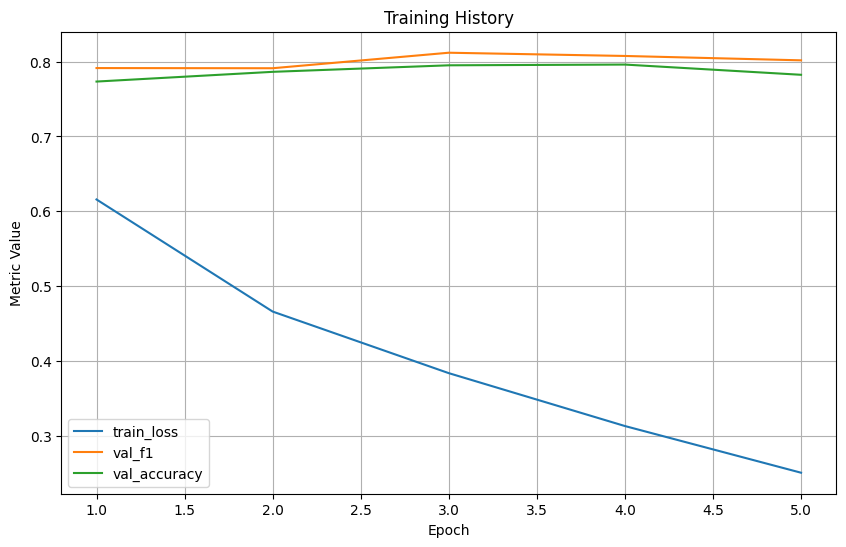

In [ ]:
draw_stats(stats=statistic, start_from=0)

In [ ]:
# plt.title("History")
# plt.plot(t_logloss, label="Log Loss History")
# plt.plot(t_loss, label="Loss History")
# plt.plot(t_accuracy, label="Accuracy history")
# plt.legend(loc="upper left")
# plt.show()

In [ ]:
# def predict(text, model, tokenizer, perplexity_model, device):
#     model.eval()

#     # –¢–æ–∫–µ–Ω–∏–∑–∞—Ü–∏—è —Ç–µ–∫—Å—Ç–∞
#     encoding = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=64)
#     input_ids = encoding["input_ids"].to(device)
#     attention_mask = encoding["attention_mask"].to(device)

#     # –ü–æ–¥—Å—á—ë—Ç –ø–µ—Ä–ø–ª–µ–∫—Å–∏–∏
#     with torch.no_grad():
#         perplexity = get_perplexity(text)
#         perplexity_tensor = torch.tensor([perplexity], dtype=torch.float).to(device)

#         # –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ
#         with torch.no_grad():
#             logits = model(input_ids, attention_mask, perplexity_tensor)
#             probs = torch.softmax(logits, dim=1)
#             predicted_class = torch.argmax(probs, dim=1).item()

#     return predicted_class, probs.squeeze().tolist()


## EVALUATION

In [ ]:
eval_data = pd.read_json(os.path.join(DATA_DIR, 'data_final_for_dls_eval_new.jsonl'), orient='orient', lines=True)
eval_data = eval_data[eval_data['relevance'] != 0.1]
eval_data = eval_data.fillna("")
# data = data[:100]
eval_data

In [ ]:
raise

RuntimeError: No active exception to reraise

In [ ]:
def predict(text, model, tokenizer, device):
    model.eval()

    # –¢–æ–∫–µ–Ω–∏–∑–∞—Ü–∏—è
    encoding = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=64).to(device)
    input_ids = encoding["input_ids"]
    attention_mask = encoding["attention_mask"]

    # –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        probs = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()

    # return predicted_class, probs.squeeze().tolist()
    return predicted_class, probs


In [ ]:
def predict_single(model, tokenizer, text, threshold=0.5, device='cpu'):
    model.eval()
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512).to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model.to(device)

    with torch.no_grad():
        logits = model(**inputs)
        probs = torch.sigmoid(logits)
        pred = (probs > threshold).int()

    # print("–ü—Ä–∏–º–µ—Ä —Ç–µ–∫—Å—Ç–∞:", text)
    # print('# ' * 10)
    # print("Tokenized:", tokenizer(text))
    # print("Logits:", logits)
    # print("Probability:", probs)
    # print("Pred:", pred)


    return pred.item(), probs.item()


In [ ]:
test_row = data.iloc[5]
test_row


Text                              –≥–¥–µ –≤ —Ä–æ—Å—Ç–æ–≤–µ –Ω–∞ –¥–æ–Ω—É –Ω–∞ —Å–µ–≤–µ—Ä–Ω–æ–º –º–æ–∂–Ω–æ —Å–¥–µ–ª–∞—Ç...
address                           –†–æ—Å—Ç–æ–≤-–Ω–∞-–î–æ–Ω—É, –º–∏–∫—Ä–æ—Ä–∞–π–æ–Ω –°–µ–≤–µ—Ä–Ω—ã–π, –ø—Ä–æ—Å–ø–µ–∫—Ç ...
name                              –ò–Ω—Å—Ç–∏—Ç—É—Ç —ç—Å—Ç–µ—Ç–∏—á–µ—Å–∫–æ–π –º–µ–¥–∏—Ü–∏–Ω—ã Sky Clinic; Ins...
normalized_main_rubric_name_ru                                         –ö–æ—Å–º–µ—Ç–æ–ª–æ–≥–∏—è
permalink                                                               10404163869
prices_summarized                 –ò–Ω—Å—Ç–∏—Ç—É—Ç —ç—Å—Ç–µ—Ç–∏—á–µ—Å–∫–æ–π –º–µ–¥–∏—Ü–∏–Ω—ã Sky Clinic –ø—Ä–µ–¥...
relevance                                                                       0.0
reviews_summarized                –û–±—â–∏–π –æ–±–∑–æ—Ä –æ—Ç–∑—ã–≤–æ–≤: –ò–Ω—Å—Ç–∏—Ç—É—Ç —ç—Å—Ç–µ—Ç–∏—á–µ—Å–∫–æ–π –º–µ–¥...
Name: 6, dtype: object

In [ ]:
text = combine_fields(test_row)
text

'–ó–∞–ø—Ä–æ—Å: –≥–¥–µ –≤ —Ä–æ—Å—Ç–æ–≤–µ –Ω–∞ –¥–æ–Ω—É –Ω–∞ —Å–µ–≤–µ—Ä–Ω–æ–º –º–æ–∂–Ω–æ —Å–¥–µ–ª–∞—Ç—å –º—Ä—Ç | –ù–∞–∑–≤–∞–Ω–∏–µ: –ò–Ω—Å—Ç–∏—Ç—É—Ç —ç—Å—Ç–µ—Ç–∏—á–µ—Å–∫–æ–π –º–µ–¥–∏—Ü–∏–Ω—ã Sky Clinic; Institute of Aesthetic Medicine Sky Clinic; Sky Clinic | –†—É–±—Ä–∏–∫–∞: –ö–æ—Å–º–µ—Ç–æ–ª–æ–≥–∏—è | –û–ø–∏—Å–∞–Ω–∏–µ: –ò–Ω—Å—Ç–∏—Ç—É—Ç —ç—Å—Ç–µ—Ç–∏—á–µ—Å–∫–æ–π –º–µ–¥–∏—Ü–∏–Ω—ã Sky Clinic –ø—Ä–µ–¥–ª–∞–≥–∞–µ—Ç —à–∏—Ä–æ–∫–∏–π —Å–ø–µ–∫—Ç—Ä –∫–æ—Å–º–µ—Ç–æ–ª–æ–≥–∏—á–µ—Å–∫–∏—Ö —É—Å–ª—É–≥, –≤–∫–ª—é—á–∞—è —á–∏—Å—Ç–∫–∏ –ª–∏—Ü–∞, –º–∞—Å—Å–∞–∂–∏, –ø–∏–ª–∏–Ω–≥–∏, –ª–∞–∑–µ—Ä–Ω—ã–µ –ø—Ä–æ—Ü–µ–¥—É—Ä—ã, –Ω–∏—Ç–µ–≤–æ–π –ª–∏—Ñ—Ç–∏–Ω–≥, –ø–ª–∞–∑–º–æ–ª–∏—Ñ—Ç–∏–Ω–≥, –º–µ–∑–æ—Ç–µ—Ä–∞–ø–∏—é, –∞ —Ç–∞–∫–∂–µ –∫–æ–Ω—Å—É–ª—å—Ç–∞—Ü–∏–∏ –≤—Ä–∞—á–µ–π | —á–∏—Å—Ç–∫–∞ –ª–∏—Ü–∞ | –º–∞—Å—Å–∞–∂ –ª–∏—Ü–∞ | –ø–∏–ª–∏–Ω–≥ | –ª–∞–∑–µ—Ä–Ω–æ–µ –æ–º–æ–ª–æ–∂–µ–Ω–∏–µ | –Ω–∏—Ç–µ–≤–æ–π –ª–∏—Ñ—Ç–∏–Ω–≥ | –ø–ª–∞–∑–º–æ–ª–∏—Ñ—Ç–∏–Ω–≥ | –º–µ–∑–æ—Ç–µ—Ä–∞–ø–∏—è | –∫–æ–Ω—Å—É–ª—å—Ç–∞—Ü–∏—è –¥–µ—Ä–º–∞—Ç–æ–ª–æ–≥–∞ | —É–¥–∞–ª–µ–Ω–∏–µ –Ω–æ–≤–æ–æ–±—Ä–∞

In [ ]:
preds, probs = predict_single(model, tokenizer, text)
preds, probs

(1, 0.9629009366035461)

In [ ]:
predicted_class, probs, logits = predict(text, model, tokenizer, device)
predicted_class, probs, logits

(0, tensor([[1.]], device='cuda:0'), tensor([[0.7874]], device='cuda:0'))

In [ ]:
test_data = data.sample(n=20, random_state=2026)
test_data

Text  \
114                          –±–∞–ª–ª–æ–Ω —É–≥–ª–µ–∫–∏—Å–ª–æ—Ç–Ω—ã–π 10 –ª   
11   –±–µ–ª–æ—Ä—É—Å—Å–∫–∏–µ –∫—É—Ö–Ω–∏ –∑–æ–≤ –≤ –º–æ—Å–∫–≤–µ –æ—Ñ–∏—Ü–∏–∞–ª—å–Ω—ã–π —Å–∞–π...   
5                                —Å–µ—Ç—å –±—ã—Å—Ç—Ä–æ–≥–æ –ø–∏—Ç–∞–Ω–∏—è   
19             –ø–∞–ª–∞—Ç—ã –≤ –º–æ—Å–∫–≤–µ –¥–æ—Å—Ç—É–ø–Ω—ã–µ –¥–ª—è –ø–æ—Å–µ—â–µ–Ω–∏—è   
102                                        –ø—Ä–æ–ø–∞–Ω –∞–≥–∑—Å   
14             –ö–∞—Ç–µ—Ç–µ—Ä—ã –±–∞–ª–ª–æ–Ω–Ω—ã–µ –¥–∏–ª–∞—Ç–∞—Ü–∏–æ–Ω–Ω—ã–µ –∫—É–ø–∏—Ç—å   
9         –≥–¥–µ –≤ —Ä—è–∑–∞–Ω–∏ –º–æ–∂–Ω–æ –∫—É–ø–∏—Ç—å –±—É—Ç–∞—Ñ–æ—Ä—Å–∫–∏–µ –¥–µ–Ω—å–≥–∏   
98                                  –ú–∞–∫–ª–∞—Ä–µ–Ω –∫–∞–∑–∞—Ö—Å—Ç–∞–Ω   
92                      –ª—É—á—à–∏–π –≥—Ä—É–∑–∏–Ω—Å–∫–∏–π —Ä–µ—Å—Ç–æ—Ä–∞–Ω —Å–ø–±   
22                                           –ü—Ä–∞—á–µ—á–Ω–∞—è   
99                                          —Å–µ–∫–µ–Ω —Ö–µ–Ω–¥   
112                  –∫—É–ø–∏—Ç—å –∂–µ–Ω—Å–∫—É—é –æ–¥–µ–∂–¥—É —é–∑–∞–æ –º–æ—Å–∫–≤–∞   
60                                       –ª–µ–Ω–∏–Ω—Å–∫–∏–π —Å—É–¥   
46                    —Ç–æ–ø –≥—Ä—É–∑–∏–Ω—Å–∫–∏—Ö —Ä–µ—Å—Ç–æ—Ä–∞–Ω–æ–≤ –º–æ—Å–∫–≤—ã   
59                      –º–∞–≥–∞–∑–∏–Ω –≤ –ª–∞–ø–ª–∞–Ω–¥–∏–∏ –≤ –∫–µ–º–µ—Ä–æ–≤–æ   
113                                         –¥–ª—è –æ—Ç–µ–ª–µ–π   
84                              –∞–≤—Ç–æ—Å–µ—Ä–≤–∏—Å—ã —à–∏–Ω–æ–º–æ–Ω—Ç–∞–∂   
6    –≥–¥–µ –≤ —Ä–æ—Å—Ç–æ–≤–µ –Ω–∞ –¥–æ–Ω—É –Ω–∞ —Å–µ–≤–µ—Ä–Ω–æ–º –º–æ–∂–Ω–æ —Å–¥–µ–ª–∞—Ç...   
67                                        –æ—Ç–µ–ª—å –Ω–∞ —á–∞—Å   
25                                             —Å–æ–ª—è—Ä–∏–π   

                                               address  \
114  –ú–æ—Å–∫–æ–≤—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å, –õ–µ–Ω–∏–Ω—Å–∫–∏–π –≥–æ—Ä–æ–¥—Å–∫–æ–π –æ–∫—Ä—É–≥,...   
11                 –ú–æ—Å–∫–≤–∞, –í–æ–ª–≥–æ–≥—Ä–∞–¥—Å–∫–∏–π –ø—Ä–æ—Å–ø–µ–∫—Ç, 132   
5       –°–∞–Ω–∫—Ç-–ü–µ—Ç–µ—Ä–±—É—Ä–≥, 1-—è –ö—Ä–∞—Å–Ω–æ–∞—Ä–º–µ–π—Å–∫–∞—è —É–ª–∏—Ü–∞, 15   
19                          –ú–æ—Å–∫–≤–∞, –ò–≤–∞–Ω–æ–≤—Å–∫–∞—è –ø–ª–æ—â–∞–¥—å   
102              –ú–æ—Å–∫–≤–∞, –ó–∞–≥–æ—Ä–æ–¥–Ω–æ–µ —à–æ—Å—Å–µ, 18–ê, —Å—Ç—Ä. 2   
14   –°–∞–Ω–∫—Ç-–ü–µ—Ç–µ—Ä–±—É—Ä–≥, –°–≤–µ—Ç–ª–∞–Ω–æ–≤—Å–∫–∏–π –ø—Ä–æ—Å–ø–µ–∫—Ç, 60, –∫...   
9                         –†—è–∑–∞–Ω—å, —É–ª–∏—Ü–∞ –ö—É–¥—Ä—è–≤—Ü–µ–≤–∞, 56   
98                    –û–º—Å–∫, –ù–µ—Ñ—Ç–µ–∑–∞–≤–æ–¥—Å–∫–∞—è —É–ª–∏—Ü–∞, 49–∫5   
92               –°–∞–Ω–∫—Ç-–ü–µ—Ç–µ—Ä–±—É—Ä–≥, –í–∞—Ä—à–∞–≤—Å–∫–∞—è —É–ª–∏—Ü–∞, 94   
22   –°–≤–µ—Ä–¥–ª–æ–≤—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å, –ï–∫–∞—Ç–µ—Ä–∏–Ω–±—É—Ä–≥, –ü–æ—Å–∞–¥—Å–∫–∞—è ...   
99          –£–ª—å—è–Ω–æ–≤—Å–∫, —É–ª–∏—Ü–∞ –ö–∞—Ä–ª–∞ –ú–∞—Ä–∫—Å–∞, 12, –∫–æ—Ä–ø. 3   
112                  –ú–æ—Å–∫–≤–∞, –ö–∏—Ä–æ–≤–æ–≥—Ä–∞–¥—Å–∫–∞—è —É–ª–∏—Ü–∞, 13–ê   
60                            –ò–≤–∞–Ω–æ–≤–æ, —É–ª–∏—Ü–∞ –°—Ç–∞–Ω–∫–æ, 7   
46                         –ú–æ—Å–∫–≤–∞, –û—Ä–ª–∏–∫–æ–≤ –ø–µ—Ä–µ—É–ª–æ–∫, 6   
59                  –ö–µ–º–µ—Ä–æ–≤–æ, –û–∫—Ç—è–±—Ä—å—Å–∫–∏–π –ø—Ä–æ—Å–ø–µ–∫—Ç, 34   
113                      –û–º—Å–∫, –í–æ–ª–æ—á–∞–µ–≤—Å–∫–∞—è —É–ª–∏—Ü–∞, 13–ì   
84                           –°–º–æ–ª–µ–Ω—Å–∫, —É–ª–∏—Ü–∞ –°–µ–¥–æ–≤–∞, 4   
6    –†–æ—Å—Ç–æ–≤-–Ω–∞-–î–æ–Ω—É, –º–∏–∫—Ä–æ—Ä–∞–π–æ–Ω –°–µ–≤–µ—Ä–Ω—ã–π, –ø—Ä–æ—Å–ø–µ–∫—Ç ...   
67                    –ú–æ—Å–∫–≤–∞, —à–æ—Å—Å–µ –≠–Ω—Ç—É–∑–∏–∞—Å—Ç–æ–≤, 11–ê–∫3   
25   –ú–æ—Å–∫–æ–≤—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å, –≥–æ—Ä–æ–¥—Å–∫–æ–π –æ–∫—Ä—É–≥ –ò—Å—Ç—Ä–∞, –î–µ–¥...   

                                                  name  \
114             –¶–µ–Ω—Ç—Ä–æ–≥–∞–∑-–ë–µ—Å–µ–¥—ã; Centrogas; –¶–µ–Ω—Ç—Ä–æ–≥–∞–∑   
11           –ö—É—Ö–Ω–∏ –ó–æ–≤; Zov; –ó–æ–≤; –ó–æ–≤ –ö—É—Ö–Ω–∏; Kuhni-zov   
5         Rostic's; KFC; –†–µ—Å—Ç–æ—Ä–∞–Ω –±—ã—Å—Ç—Ä–æ–≥–æ –ø–∏—Ç–∞–Ω–∏—è KFC   
19   –ú–æ—Å–∫–æ–≤—Å–∫–∏–π –ö—Ä–µ–º–ª—å; Moscow Kremlin; –ú–∞—Å–∫–æ—û—Å–∫—ñ –ö...   
102  –ù–∞—É—á–Ω–æ-–∏—Å—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å—Å–∫–∏–π –∫–ª–∏–Ω–∏—á–µ—Å–∫–∏–π –∏–Ω—Å—Ç–∏—Ç—É—Ç ...   
14   –ú–µ–¥—Ç–µ—Ö–Ω–∏–∫–∞-1; Medtechnika-1; Medtech-1; Medteh...   
9    –ì–∞–∑–ø—Ä–æ–º–±–∞–Ω–∫; Gazprombank; –ì–∞–∑–ø—Ä–æ–º–±–

In [ ]:
for i, row in test_data.iterrows():
    text = combine_fields(row)
    # pred1, prob1 = predict(text, model, tokenizer, device)
    pred2, prob2 = predict_single(model, tokenizer, text, device=device)
    print(f"{row['relevance']} / {pred2}: {prob2}")

1.0 / 1: 0.9358146786689758
0.0 / 0: 0.03273127228021622
1.0 / 1: 0.9750092625617981
0.0 / 1: 0.9629009366035461
0.0 / 0: 0.04964868724346161
0.0 / 0: 0.4745849072933197
0.0 / 1: 0.9629009366035461
1.0 / 1: 0.9629009366035461
1.0 / 1: 0.8752132058143616
1.0 / 1: 0.9428630471229553
1.0 / 1: 0.9776723980903625
1.0 / 1: 0.9629009366035461
1.0 / 1: 0.9629009366035461
1.0 / 1: 0.9629009366035461
1.0 / 1: 0.9629009366035461
0.0 / 1: 0.9629009366035461
1.0 / 1: 0.9629009366035461
0.0 / 0: 0.023964405059814453
1.0 / 1: 0.6715292930603027
1.0 / 1: 0.9629009366035461


In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def plot_threshold_metrics(y_true, y_probs):
    # ROC
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    # PR curve
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_probs)

    # Plot ROC
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title("ROC Curve")
    plt.legend()

    # Plot Precision-Recall
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label="PR Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # –ù–∞–π—Ç–∏ –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã–π threshold –ø–æ –º–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–º—É F1
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds_pr[best_idx]

    print(f"üéØ –û–ø—Ç–∏–º–∞–ª—å–Ω—ã–π threshold –ø–æ F1: {best_threshold:.4f}")
    print(f"üîÅ Precision: {precision[best_idx]:.4f} | Recall: {recall[best_idx]:.4f} | F1: {f1_scores[best_idx]:.4f}")
    return best_threshold


In [ ]:
for i in val_loader:
    print(i)
    break

{'input_ids': tensor([[    0,     0,     0,  ...,  1649,  5418,  6814],
        [  280,   317,   281,  ...,  5852,   547,  6715],
        [    0,     0,     0,  ...,   289, 13286,    18],
        ...,
        [    0,     0,     0,  ..., 10360,   668, 18081],
        [ 1032,  4922,   313,  ...,   294, 20038,    18],
        [    0,     0,     0,  ...,   368,  5322,  2682]]), 'attention_mask': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]]), 'labels': tensor([1., 1., 1., 1., 0., 0., 0., 1.])}


In [ ]:
y_true = []
y_probs = []

model.eval()
with torch.no_grad():
    for i, batch in data.iterrows():  # –∏–ª–∏ –ø—Ä–æ—Å—Ç–æ —Å–ø–∏—Å–æ–∫ —Ç–µ–∫—Å—Ç–æ–≤ + –º–µ—Ç–∫–∏
        text = combine_fields(batch)  # –∏–ª–∏ —Å–æ–±—Ä–∞–Ω–Ω—ã–π —à–∞–±–ª–æ–Ω
        label = batch['relevance']
        
        # tokenizer(...) ‚Üí predict_single or batched logic
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        logits = model(**inputs)
        prob = torch.sigmoid(logits).cpu().numpy().flatten()[0]

        y_probs.append(prob)
        y_true.append(label)


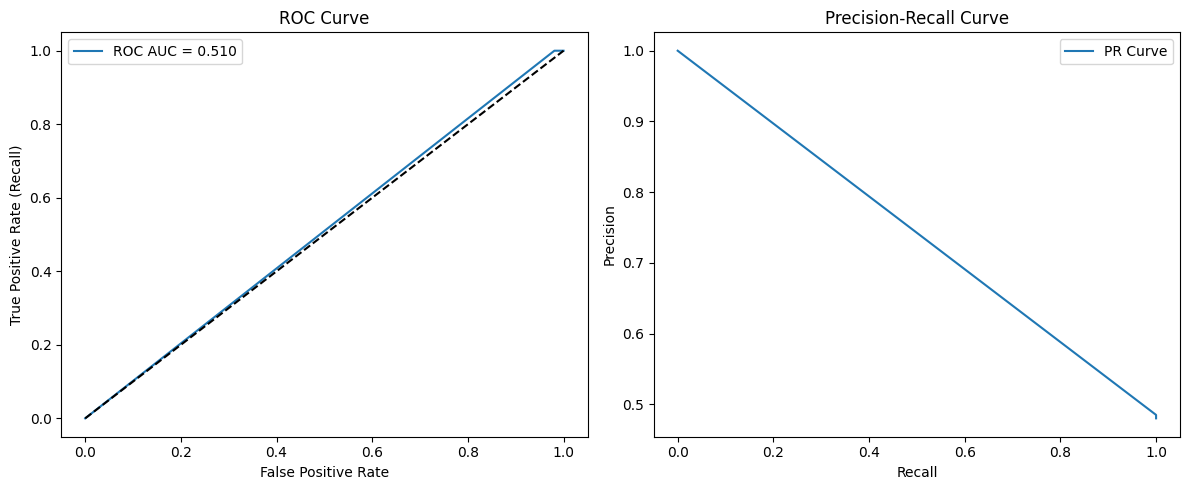

üéØ –û–ø—Ç–∏–º–∞–ª—å–Ω—ã–π threshold –ø–æ F1: 0.9629
üîÅ Precision: 0.4848 | Recall: 1.0000 | F1: 0.6531


In [ ]:
best_threshold = plot_threshold_metrics(y_true, y_probs)

In [ ]:
raise

In [ ]:
# –£ —Ç–µ–±—è –¥–æ–ª–∂–Ω–æ –±—ã—Ç—å —á—Ç–æ-—Ç–æ —Ç–∞–∫–æ–µ:
perplexity_model = AutoModelForCausalLM.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2").to(device)
perplexity_tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")

# –ó–∞—Ç–µ–º –≤—ã–∑—ã–≤–∞–π predict —Ç–∞–∫:
label, prob = predict(
    text,
    model=model,  # —Ç–≤–æ–π –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä
    tokenizer=tokenizer,  # —Ç–æ–∫–µ–Ω–∏–∑–∞—Ç–æ—Ä –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä–∞
    perplexity_model=perplexity_model,  # —è–∑—ã–∫–æ–≤–∞—è –º–æ–¥–µ–ª—å!
    perplexity_tokenizer=perplexity_tokenizer,
    device=device
)

print(label, prob)

In [ ]:
tqdm.pandas()  # –∞–∫—Ç–∏–≤–∏—Ä—É–µ—Ç tqdm –¥–ª—è pandas

In [ ]:
def load_test_data(data_file: str, labels_file: str):
    df_info = pd.read_csv(labels_file)

    with open(data_file, "r", encoding="utf-8") as f:
        data = json.load(f)

    all_texts = []
    ids = []

    for _, row in df_info.iterrows():
        dialog_id = row["dialog_id"]
        participant_index = str(row["participant_index"])
        messages = data[dialog_id]

        texts = [
            m["text"] for m in messages if m["participant_index"] == participant_index
        ]
        combined_text = " ".join(texts)
        all_texts.append(combined_text)
        ids.append(row["ID"])

    df = pd.DataFrame({"ID": ids, "text": all_texts})
    return df

In [ ]:
df_test = load_test_data(f"{PROJECT_DIR}/you-are-bot/test.json", f"{PROJECT_DIR}/you-are-bot/ytest.csv")

In [ ]:
df = df_test.copy()

In [ ]:
def process_row(row):
    predicted_class, probs = predict(
    row['text'],
    model=model,  # —Ç–≤–æ–π –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä
    tokenizer=tokenizer,  # —Ç–æ–∫–µ–Ω–∏–∑–∞—Ç–æ—Ä –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä–∞
    perplexity_model=perplexity_model,  # —è–∑—ã–∫–æ–≤–∞—è –º–æ–¥–µ–ª—å!
    perplexity_tokenizer=perplexity_tokenizer,
    device=device
)
    return pd.Series([predicted_class, probs[1]])

In [ ]:
df[['preds', 'probs']] = df.progress_apply(process_row, axis=1)

In [ ]:
df['preds'] = df['preds'].astype('int')

In [ ]:
df

In [ ]:
# preds_df = pd.DataFrame({"ID": df["ID"], "is_bot": df['probs']})
# preds_df.to_csv("preds.csv", index=False)